In [206]:
# Runner 类框架定义
class Runner(object):
    def __init__(self,model,optimizer,loss_fn,metric):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
    #模型训练
    def train(self,train_dataset,dev_dataset = None, **kwargs):
        pass
    #模型评价
    def evaluate(self,data_set,**kwargs):
        pass
    #模型预测
    
    def predict(self,x,**kwargs):
        pass
    
    #模型保存
    def save(self,sava_path):
        pass
    
    #模型加载
    def load(self,model_path):
        pass
    


1.读取数据

In [207]:
import pandas as pd

data = pd.read_csv('/home/wu/code/priactice-in-torch-main/chap2机器学习概述/boston.csv')
data.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10,18.9


2. 检查空值

In [208]:
data.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

3. 利用箱线图检查异常值

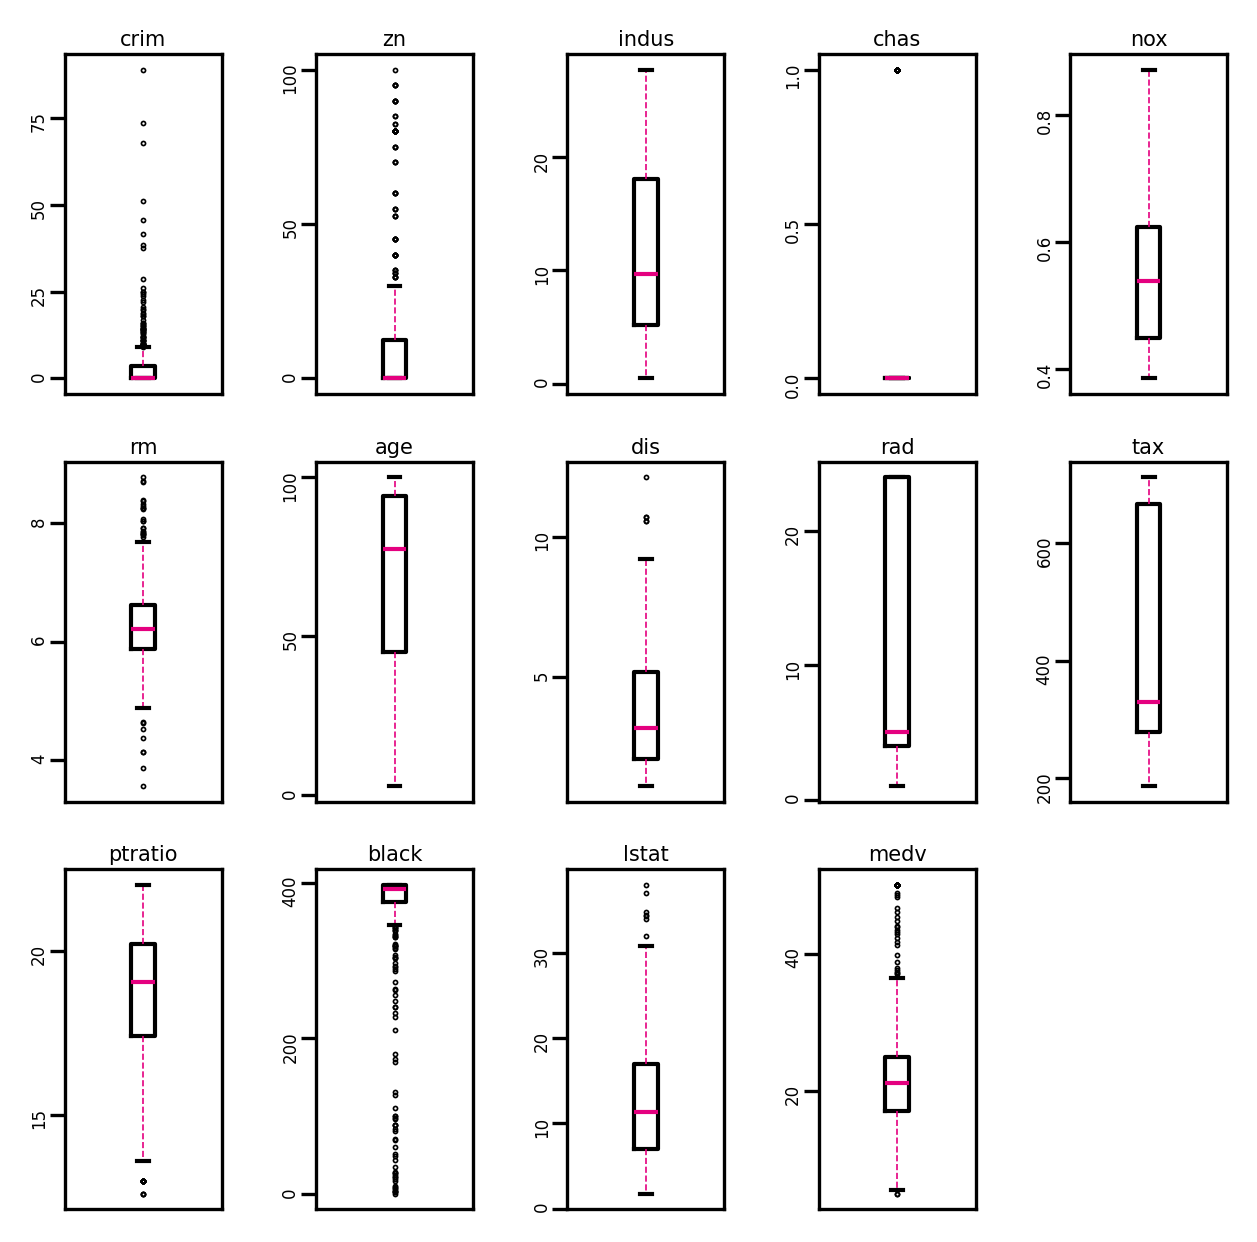

In [209]:
import matplotlib.pyplot as plt
#箱线图查看异常值分布
def boxplot(data, fig_name):
    data_col = list(data.columns)
    plt.figure(figsize=(5,5),dpi=300)
    plt.subplots_adjust(wspace=0.6)
    
    for i,col_name in enumerate(data_col):
        plt.subplot(3,5,i+1)
        plt.boxplot(
            data[col_name],
            showfliers=True,
            meanprops={'markersize':1,"marker":"D","markeredgecolor":'#f19ec2'},
            medianprops={"color":'#e4007f'}, # 中位数线的属性
             whiskerprops={"color":'#e4007f', "linewidth":0.4, 'linestyle':"--"},
            flierprops={"markersize":0.4},
        )
        plt.title(col_name,fontdict={'size':5},pad=2)
        plt.yticks(fontsize=4,rotation=90)
        plt.tick_params(pad=0.5)
        plt.xticks([])
    plt.savefig(fig_name)
    plt.show()
   
boxplot(data,'ml-vis5.pdf')

4. 处理异常值，将异常值统一处理成最大值和最小值

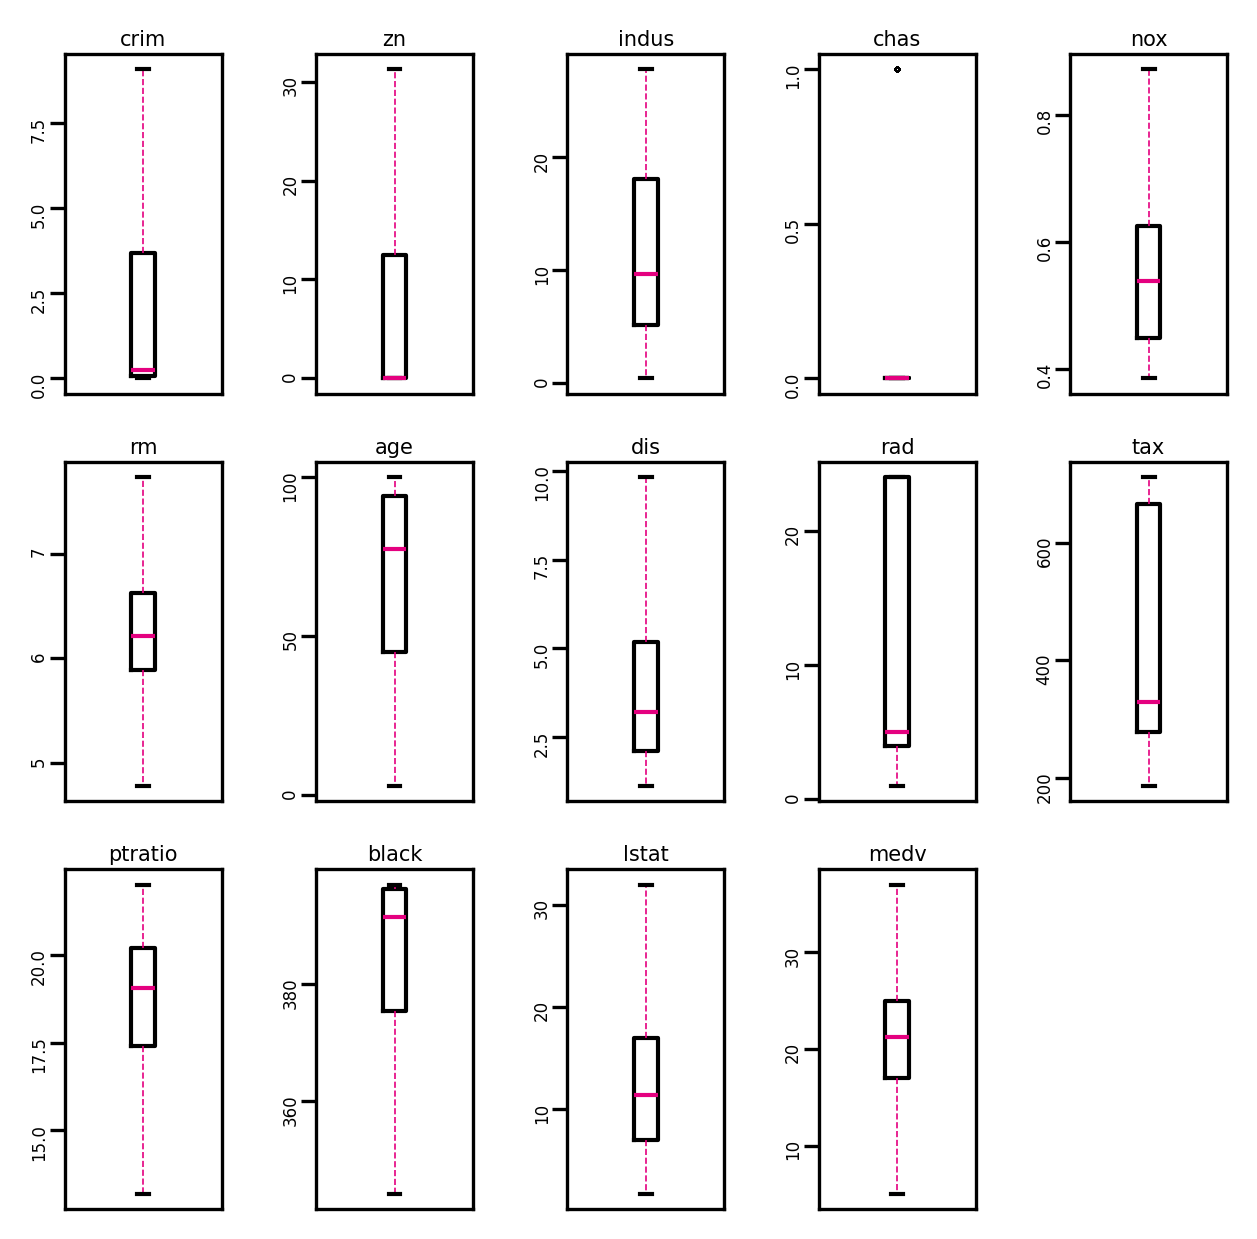

In [210]:
num_features = data.select_dtypes(exclude=['object','bool']).columns.tolist()

for feature in num_features:
    if feature == 'chas':
        continue

    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    
    IQR = Q3 - Q1
    top = Q3 + 1.5 * IQR
    bot = Q1 - 1.5 * IQR
    
    values = data[feature].values
    values[values > top] = top
    values[values < bot] = bot
    
    data[feature] = values.astype(data[feature].dtypes)

boxplot(data,'ml-vis6.pdf')


5. 划分数据集和训练集

In [214]:
import torch

torch.manual_seed(10)

def train_test_split(X,y,train_percent=0.8):
    n = len(X)
   
    shuffled_indices = torch.randperm(n)
    train_set_size = int(n*train_percent)
    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]
    
    X=X.values
    y=y.values
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    return X_train,y_train,X_test,y_test

X = data.drop(['medv'],axis=1)
y = data['medv']

x_train,y_train,x_test,y_test = train_test_split(X,y)

6. 数据归一化处理

In [215]:
X_train = torch.tensor(x_train,dtype=torch.float32).clone().detach()
X_test = torch.tensor(x_test,dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train,dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test,dtype=torch.float32).clone().detach()

X_min, _ = torch.min(X_train,dim=0)
X_max, _ = torch.max(X_train,dim=0)

X_train = (X_train - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

train_dataset = (X_train,y_train)
test_dataset = (X_test,y_test)

7. 模型构建

In [216]:
from nndl2.op2 import Linear
input_size = 13
model = Linear(input_size)

In [217]:
import torch.nn as nn
mse_loss = nn.MSELoss()

In [218]:
import os
from nndl2 import opitimizer2

class Runner(object):
    def __init__(self,model,optimizer,loss_fn,metric):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
        
    def train(self,dataset,reg_lambda,model_dir):
        X,y=dataset
        self.optimizer(self.model,X,y,reg_lambda)
        
        self.save_model(model_dir)
        
    def evaluate(self,dataset,**kwargs):
        X,y = dataset
        
        y_pred = self.model.forward(X)
        result = self.metric(y_pred,y)
        
        return result
    def predict(self,X,**kwargs):
        return self.model(X)
    
    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        params_saved_path = os.path.join(model_dir, 'params.pdtensor')
        torch.save(model.params,params_saved_path)
        
    def load_model(self,model_dir):
        params_saved_path = os.path.join(model_dir, 'params.pdtensor')
        torch.save(model.params,params_saved_path)
        

8.模型训练


In [219]:

optimizer = opitimizer2.optimizer_lsm
        #实例化Runner
runner = Runner(model=model,optimizer=optimizer,loss_fn=None,metric=mse_loss)
sava_dir = '/home/wu/code/priactice-in-torch-main/chap2机器学习概述'
runner.train(train_dataset,reg_lambda=0,model_dir=sava_dir)

9.打印权重

In [220]:
column_list = data.columns.tolist()
weights = runner.model.params['w'].tolist()
b = runner.model.params['b'].item()

for i in range(len(weights)):
    print(f'{column_list[i]}的权重为{weights[i]}')
    
print(f'偏置为{b}',b)

crim的权重为-5.295190811157227
zn的权重为1.3773244619369507
indus的权重为-0.05789320170879364
chas的权重为1.8000911474227905
nox的权重为-7.619860649108887
rm的权重为9.569478988647461
age的权重为-1.3474974632263184
dis的权重为-10.01346206665039
rad的权重为7.5344319343566895
tax的权重为-5.120015621185303
ptratio的权重为-6.955477237701416
black的权重为-0.17988094687461853
lstat的权重为-13.187442779541016
偏置为32.783687591552734 32.783687591552734


10. 模型测试

In [221]:
runner.load_model(sava_dir)
mse = runner.evaluate(test_dataset)
print('MSE:',mse)

MSE: tensor(11.3096)


11.模型预测

In [222]:
runner.load_model(sava_dir)
pred = runner.predict(X_test[:1])
print('真实的房价是',y_test[:1].item())
print('预测的房价是',pred.item())

真实的房价是 18.899999618530273
预测的房价是 21.472036361694336
